In [90]:
%matplotlib inline
import matplotlib.pyplot as plt

In [91]:
def compute_gini(model):
    agent_wealths = [agent.puntos for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B

def sumPoint(model)->int:
    x =  [agent.puntos for agent in model.schedule.agents]
    y = sum(x)
    return y

In [92]:
import mesa
class AspiradoraAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.puntos = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def clean(self):
        cell = self.model.grid.get_cell_list_contents([self.pos])
        # print(cell)
        for element in cell:
            if isinstance(element, TrashAgent) == True:
                self.model.grid.remove_agent(element)
                self.puntos += 1

    def step(self):
        self.move()
        self.clean()


class AspiradoraModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, Basura, width, height):
        self.num_agents = N
        self.basura = Basura

        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.schedule2 = mesa.time.RandomActivation(self)
        self.running = True
        
        for i in range(self.num_agents):
            a = AspiradoraAgent(i, self)
            self.schedule.add(a)
            self.grid.place_agent(a, (0, 0))

        for i in range(self.basura):
            a = TrashAgent(i + self.num_agents, Basura)
            self.schedule2.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))



        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Puntos": "puntos"}
        )
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        suma = sumPoint(self)
        if (suma == 25):
            self.running = False
    

class TrashAgent(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)


Text(0, 0.5, 'Steps')

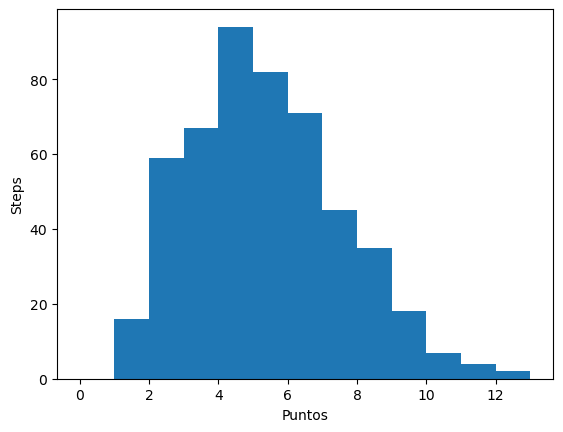

In [93]:
all_wealth = []

# This runs the model 100 times, each model executing 10 steps.
for j in range(100):
    # Run the model
    model = AspiradoraModel(5, 20, 10, 10)
    for i in range(100):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.puntos)

plt.hist(all_wealth, bins=range(max(all_wealth) + 1))
plt.xlabel("Puntos")
plt.ylabel("Steps")

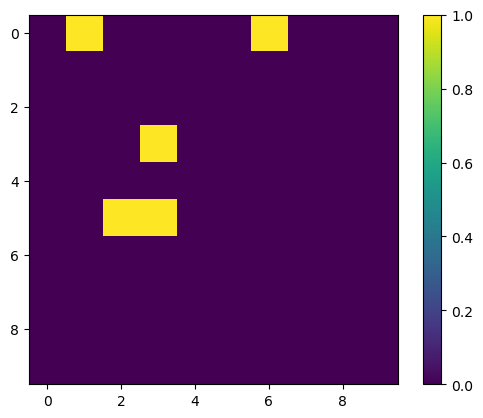

In [94]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation="nearest")
plt.colorbar()

In [95]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.tail()

Puntos
Step AgentID        
99   0             2
     1             5
     2             2
     3             7
     4             9

Text(0, 0.5, 'Valor del gini')

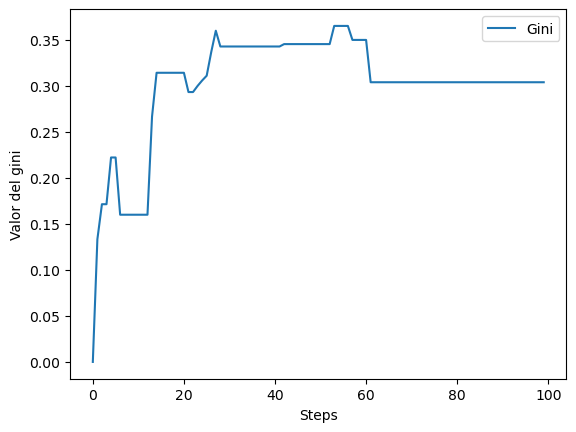

In [96]:
gini = model.datacollector.get_model_vars_dataframe()
a= gini.plot()
a.set_xlabel("Steps")
a.set_ylabel("Valor del gini")

In [97]:
params = {"width": 10,  "height": 10, "N": 5,"Basura": 20}
results = mesa.batch_run(
    AspiradoraModel,
    parameters=params,
    iterations=5,
    max_steps=50,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 269.28it/s]


In [98]:
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'N', 'Basura', 'Gini',
       'AgentID', 'Puntos'],
      dtype='object')


Text(0, 0.5, 'Puntos')

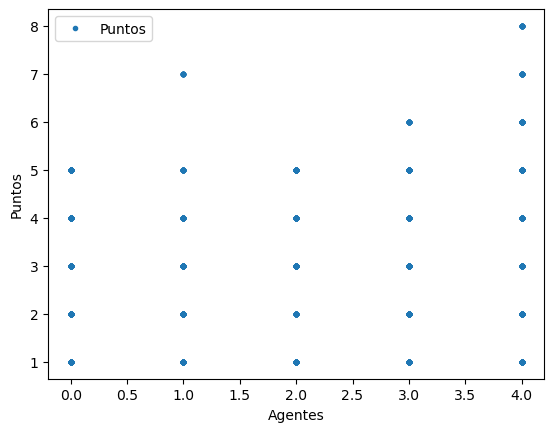

In [99]:
ax = results_df.plot(x='AgentID', y='Puntos', style='.')
ax.set_xlabel("Agentes")
ax.set_ylabel("Puntos")

Text(0, 0.5, 'Puntos')

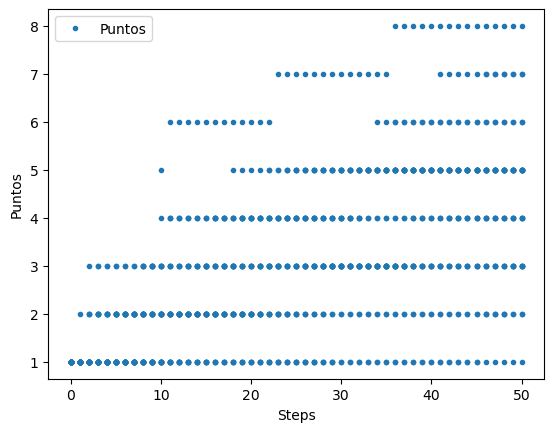

In [100]:
bx = results_df.plot(x='Step', y='Puntos',style='.')
bx.set_xlabel("Steps")
bx.set_ylabel("Puntos")


Text(0, 0.5, 'Número de aspiradoras')

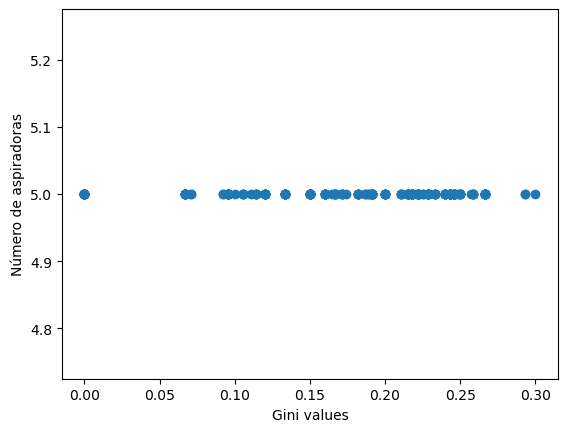

In [101]:
results_filtered = results_df[(results_df.AgentID == 0) & (results_df.Step <= 100)]

N_values = results_filtered.N.values
gini_values = results_filtered.Gini.values
plt.scatter(gini_values,N_values)
plt.xlabel("Gini values")
plt.ylabel("Número de aspiradoras")

In [102]:
# First, we filter the results
one_episode_wealth = results_df#[(results_df.N == 10) & (results_df.iteration == 2)]
# Then, print the columns of interest of the filtered data frame
print(
    one_episode_wealth.to_string(
        index=False, columns=["Step", "AgentID", "Puntos"], max_rows=25
    )
)

 Step  AgentID  Puntos
    0        0       1
    0        1       1
    0        2       1
    0        3       1
    0        4       1
    1        0       1
    1        1       1
    1        2       1
    1        3       1
    1        4       1
    2        0       1
    2        1       2
  ...      ...     ...
   48        3       3
   48        4       5
   49        0       4
   49        1       7
   49        2       5
   49        3       3
   49        4       5
   50        0       4
   50        1       7
   50        2       5
   50        3       3
   50        4       5


In [103]:
results_one_episode = results_df

print(results_one_episode.to_string(index=False, columns=["Step", "Gini"], max_rows=25))

 Step  Gini
    0  0.00
    0  0.00
    0  0.00
    0  0.00
    0  0.00
    1  0.00
    1  0.00
    1  0.00
    1  0.00
    1  0.00
    2  0.25
    2  0.25
  ...   ...
   48  0.15
   48  0.15
   49  0.15
   49  0.15
   49  0.15
   49  0.15
   49  0.15
   50  0.15
   50  0.15
   50  0.15
   50  0.15
   50  0.15
